## 4.1 Sales Prediction

We'll continue by examining the sales trends of a few handpicked categories:

In [2]:
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

In [ ]:
To build a line plot of monthly sales for each category, we'll need a matrix of the sum of sales where columns are categories and rows are months:

In [3]:
import sqlite3
import pandas as pd
db_path = '/content/drive/MyDrive/Olist E-Commerce/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [4]:
monthly_sales_selected_categories = f"""
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df

,health_beauty,auto,toys,electronics,fashion_shoes
year_month,,,,,
2017-01,12561.32,5218.53,4814.09,617.00,34.90
2017-02,22838.79,13162.40,9403.34,1218.85,107.05
2017-03,25995.25,14482.07,12429.47,3986.00,1515.00
2017-04,22935.75,15548.17,13039.43,4822.24,1526.50
2017-05,46786.02,18640.03,22626.95,6709.11,1669.54
2017-06,32029.39,31370.69,15476.35,2100.04,1351.20
2017-07,34896.86,14119.74,24511.72,7346.84,1423.01
2017-08,49873.90,20421.11,18126.87,2854.15,1491.69
2017-09,51537.65,14544.67,31399.22,4338.96,1179.60


There's little data before 2017-01-01, so I ignored the few orders made before that time. Let's plot the time series:

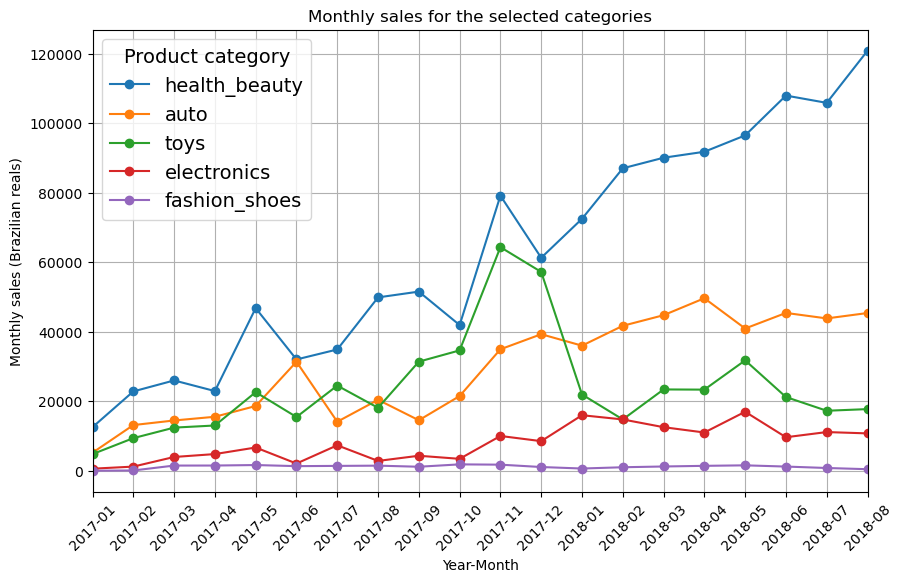

In [7]:
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

I selected these categories because they are diverse, each showcasing a unique trend. At the bottom, highlighted in purple, is **fashion_shoes**, the lowest-performing category among the five. Its sales remain fairly stagnant, fluctuating between 1,000 and 1,500 reals per month throughout the time frame of the dataset. In contrast, the categories **electronics** (red), **auto** (orange), and **health_beauty** (blue) exhibit steady linear growth, each progressing at a different rate. On the other hand, **toys** show a dramatic spike during the holiday season, with sales nearly tripling in November and December before quickly returning to their baseline.

## 4.2 Linear regression

We can use linear regression to forecast sales for the next holiday season. To achieve this, first we need to get the data we need to calculate the regression line for each category: days, the independent variable, that should be in numeric format, so we'll count the days that have passed since 2017-01-01; and total sales per day and category. The resulting query is:

In [9]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


We can use the previous query as a CTE, from which we can calculate the slope and intercept of the regression line for each category using the least squares method. The formula to calculate the slope is:

slope = (n * sum_day_sales - sum_day * sum_sales) / (n * sum_day_squared - sum_day ** 2)

And the intercept is:

intercept = (sum(sales) - slope * sum(day)) / n

Where n is the count of rows per category:

In [10]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    -- Slope
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    -- Intercept
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

,category,slope,intercept
0,auto,2.257831,319.055318
1,electronics,0.614535,105.302974
2,fashion_shoes,0.126815,89.637179
3,health_beauty,5.876734,305.451543
4,toys,0.563910,649.648518


Let's see the regression lines for each category:

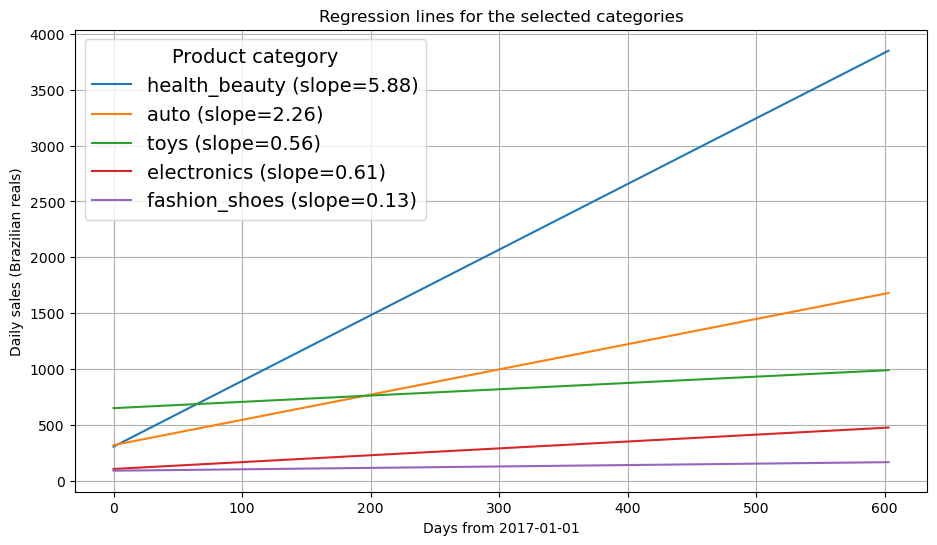

In [11]:
import numpy as np

plt.figure(figsize=(11, 6))
days = np.arange(0, 604)
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})')
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

If we assume the trends in the regression lines for each category will continue in the following months, we can use them to forecast daily sales. To calculate the predicted sales for each day in december 2018 I will multiply the increase in sales from december 2017 to december 2018 with the sales of each day of december 2017:

sales_day_plus_365 = intercept + slope * (day + 365)

We can see the previous formula in the ForecastedSales CTE. In the main query, I will use the daily forecasts to calculate the 5-day moving average, to remove noise due to daily fluctuations in sales:

In [13]:
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        -- Increase in predicted sales * sales 1 year ago
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    -- Filter for days of December 2018
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,
    category,
    -- 5-day moving average
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

,december_2018_day,category,moving_avg_sales
0,1,auto,2438.257278
1,2,auto,2957.096207
2,3,auto,2612.112277
3,4,auto,3034.655653
4,5,auto,2919.956942
...,...,...,...
126,27,toys,1247.841517
127,28,toys,857.343323
128,29,toys,585.209963
129,30,toys,621.773116


In the next plot, we can see the predicted sales for december 2018 for each category:

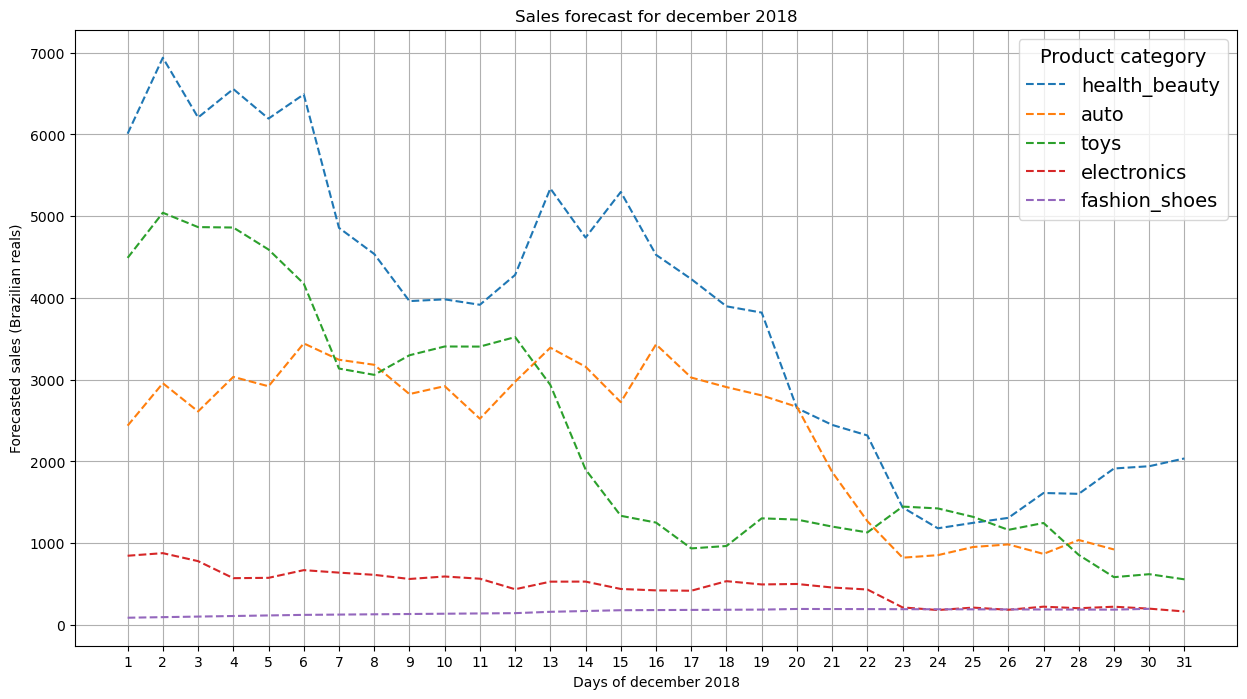

In [14]:
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

Our model predicts that **health_beauty** will be the highest selling category of the five we examined, and its sales will slowly go down until Christmas. **toys** will have strong sales for the first two weeks but decline sharply after that. **auto** sales remain stable for the first 3 weeks, but they'll go down afterward. **electronics** follows a similar trend but **fashion_shoes** sales seem to be independent of the holiday trends, increasing slightly at the end of the month.